# 作业05：中草药识别

1. **作业概述**：使用任意的神经网络模型实现对中草药图像的识别；
2. **基本要求**：
	1. 实现任意的神经网络模型，完成中草药的图像识别任务；
	2. 对训练过程中训练集和验证集上损失函数和准确率的变化过程进行可视化并上传其结果；
	3. 在README文件中描述模型的结构、优化过程，在测试集上的表现以及其他重要信息；
3. **加分项**：对模型进行优化，或者对模型的训练过程/结果进行可视化。

In [1]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from paddle.io import Dataset
from paddle.vision import transforms
from paddle.vision.transforms import Compose
# random.seed(200)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [2]:
print(paddle.__version__)

2.0.2


In [3]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                              #输入图片的shape
    #"input_size": [3, 96, 96],  
    "class_dim": 5,                                          #分类数
    "src_path":"/home/aistudio/data/data55190/Chinese Medicine.zip",    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 60,                                         #训练轮数
    "train_batch_size": 32,                                    #训练时每个批次的大小
    "skip_steps": 10,
    "save_steps": 100, 
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0001                                          #超参数学习率
    },
    "checkpoints": "/home/aistudio/work/checkpoints"          #保存的路径
}

## 一、 数据准备

1. 解压原始数据集；
2. 划分训练集和验证集；
3. 生成数据列表；
4. 定义数据读取器。

In [4]:
def unzip_data(src_path, target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "Chinese Medicine")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [5]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"Chinese Medicine/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别，['river', 'lawn','church','ice','desert']
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
  
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [6]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

生成数据列表完成！


In [7]:
class dataset(Dataset):
    def __init__(self, data_path, mode='train', transform=None):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []
        self.transform = transform
        self.mode = mode

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        if self.mode == 'train' and self.transform:  # 训练时进行图像增强
            img = self.transform(img) 
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [8]:
#训练数据加载
train_transforms = Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15)
])
train_dataset = dataset('/home/aistudio/data',mode='train', )
train_loader = paddle.io.DataLoader(train_dataset, batch_size=32, shuffle=True)
#测试数据加载
eval_dataset = dataset('/home/aistudio/data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size=8, shuffle=False)

In [9]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/data/Chinese Medicine/huaihua/huaihua_145.jpg 	标签值 0
787
文件名 /home/aistudio/data/Chinese Medicine/dangshen/dangshen_208.jpg 	标签值 3
115
(3, 224, 224)
(1,)


## 二、 模型配置

完成神经网络模型的搭建和超参数的设置。

In [10]:
# class Model(paddle.nn.layer):
#     pass

#### 模型1： VGG 网络

In [11]:
class ConvPool(paddle.nn.Layer):
    '''
    卷积 + 池化 模块
    '''
    def __init__(self, num_channel, num_filter,
                filter_size,pool_size, pool_stride, groups,
                conv_stride=1,conv_padding=1,):
                super(ConvPool, self).__init__()

                for i in range(groups):
                    # conv
                    self.add_sublayer(
                        'bb_%d' % i,
                        paddle.nn.Conv2D(             # one conv layer
                            in_channels=num_channel,  # 输入通道 
                            out_channels=num_filter,  # 卷积核个数， 输出通道个数
                            kernel_size=filter_size,  # 卷积核大小
                            stride=conv_stride,       # 步长
                            padding=conv_padding,     # padding
                        )
                    )
                    # relu
                    self.add_sublayer(
                        'relu%d' % i,
                        paddle.nn.ReLU()
                    )
                    num_channel = num_filter
                
                self.add_sublayer(
                    'maxpool',
                    paddle.nn.MaxPool2D(
                        kernel_size=pool_size,
                        stride=pool_stride
                    )
                )
    def forward(self, inputs):
        out = inputs
        for prefix, sub_layer in self.named_children():
            out = sub_layer(out)
        return out



In [12]:
class VGGNet(paddle.nn.Layer):
    def __init__(self):
        super(VGGNet, self).__init__()
        # 5 conv
        self.conv1 = ConvPool(3, 64, 3, 2, 2, 2)  # 输入通道， 卷积核个数，卷积核大小，池化核大小，池化步长，连续卷积个数
        self.conv2 = ConvPool(64, 128, 3, 2, 2, 2)
        self.conv3 = ConvPool(128, 256, 3, 2, 2, 3)
        self.conv4 = ConvPool(256, 512, 3, 2, 2, 3)
        self.conv5 = ConvPool(512, 512, 3, 2, 2, 3)

        self.pool_5_shape = 512 * 7 * 7
        # three dense
        self.fc1 = paddle.nn.Linear(self.pool_5_shape, 4096)
        self.drop1 = paddle.nn.Dropout(p=0.5)
        self.fc2 = paddle.nn.Linear(4096, 4096)
        self.drop2 = paddle.nn.Dropout(p=0.5)
        self.fc3 = paddle.nn.Linear(4096, train_parameters['class_dim'])
    
    def forward(self, inputs, label=None):
        # print('input_shape:', inputs.shape) #[8, 3, 224, 224]
        """前向计算"""
        out = self.conv1(inputs)
        # print('conv1_shape:', out.shape)           #[8, 64, 112, 112]
        out = self.conv2(out)
        # print('conv12_shape:', out.shape)           #[8, 128, 56, 56]
        out = self.conv3(out)
        # print('conv13_shape:', out.shape)           #[8, 256, 28, 28]
        out = self.conv4(out)
        # print('conv14_shape:', out.shape)           #[8, 512, 14, 14]
        out = self.conv5(out)
        # print('conv15_shape:', out.shape)           #[8, 512, 7, 7] 

        out = paddle.reshape(out, shape=[-1, 512*7*7])
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.fc3(out)

        if label is not None:
            acc = paddle.metric.accuracy(input=out,label=label)
            return out, acc
        else:
            return out

## resnet18

In [13]:
# 首先实现中间两个卷积层，Skip Connection 1x1 卷积层的残差模块。代码如下：
# 残差模块
import paddle.nn as nn
import paddle.nn.functional as F
class Residual(nn.Layer):
    def __init__(self, in_channel, out_channel, use_conv1x1=False, stride=1):
        super(Residual, self).__init__()
        
        # 第一个卷积单元
        self.conv1 = nn.Conv2D(in_channel, out_channel, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2D(out_channel)
        self.relu = nn.ReLU()

        # 第二个卷积单元
        self.conv2 = nn.Conv2D(out_channel, out_channel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2D(out_channel)

        if use_conv1x1: #使用1x1卷积核完成shape匹配,stride=2实现下采样
            self.skip = nn.Conv2D(in_channel, out_channel, kernel_size=1, stride=stride)
        else:
            self.skip = None

    def forward(self, x):
        # 前向计算
        # [b, c, h, w], 通过第一个卷积单元
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 通过第二个卷积单元
        out = self.conv2(out)
        out = self.bn2(out)
        #  通过 identity 模块
        if self.skip:
            x = self.skip(x)
        #  2 条路径输出直接相加,然后输入激活函数
        output = F.relu(out + x)

        return output


# 通过build_resblock 可以一次完成2个残差模块的创建。代码如下：
def build_resblock(in_channel, out_channel, num_layers, is_first=False):
    if is_first:
        assert in_channel == out_channel
    block_list = []
    for i in range(num_layers):
        if i == 0 and not is_first:
            block_list.append(Residual(in_channel, out_channel, use_conv1x1=True, stride=2))
        else:
            block_list.append(Residual(out_channel, out_channel))
    resNetBlock = nn.Sequential(*block_list) #用*号可以把list列表展开为元素
    return resNetBlock

# 下面来实现ResNet18网络模型。代码如下：
class ResNet18_1(nn.Layer):
    # 继承paddle.nn.Layer定义网络结构
    def __init__(self,num_classes=5):
        super(ResNet18_1, self).__init__()
        # 初始化函数(根网络，预处理)
        # x:[b, c, h ,w]=[b,3,224,224]
        self.features = nn.Sequential(
            nn.Conv2D(in_channels=3, out_channels=64, kernel_size=7, 
            stride=2, padding=3),# 第一层卷积,x:[b,64,112,112]
            nn.BatchNorm2D(64),# 归一化层
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=3, stride=2, padding=1)# 最大池化，下采样,x:[b,64,56,56]
        )
        
        # 堆叠 4 个 Block，每个 block 包含了多个残差模块,设置步长不一样
        self.layer1 = build_resblock(64, 64, 2, is_first=True) # x:[b,64,56,56]
        self.layer2 = build_resblock(64, 150, 2) # x:[b,150,28,28]
        self.layer3 = build_resblock(150, 360, 2)  # x:[b,360,14,14]
        self.layer4 = build_resblock(360, 720, 2)  # x:[b,720,7,7]

        # 通过 Pooling 层将高宽降低为 1x1,[b,720,1,1]
        self.avgpool = nn.AdaptiveAvgPool2D(1)
        # 需要拉平为[b,720],不能直接输出连接线性层
        self.flatten = nn.Flatten()
        # 最后连接一个全连接层分类
        self.fc = nn.Linear(in_features=720,out_features=num_classes)

    def forward(self, inputs, label=None):
        # 前向计算函数：通过根网络
        x = self.features(inputs)
        # 一次通过 4 个模块
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # 通过池化层
        x = self.avgpool(x)
        # 拉平
        x = self.flatten(x)
        # 通过全连接层
        x = self.fc(x)
        if label is not None:
            acc = paddle.metric.accuracy(input=x,label=label)
            return x, acc
        else:
            return x


## resnet50

In [14]:
from paddle.nn.layer.common import Dropout 
from paddle.vision.transforms import Compose, Resize, Transpose, Normalize, ToTensor

# 构建ResNet50网络
# Sequential：顺序容器，子Layer将按构造函数参数的顺序添加到此容器中，传递给构造函数的参数可以Layers或可迭代的name Layer元组
from paddle.nn import Sequential, Conv2D, ReLU, MaxPool2D, Linear, Dropout, Flatten, BatchNorm2D, AvgPool2D

#构建模型
class Residual(paddle.nn.Layer):
    def __init__(self, in_channel, out_channel, use_conv1x1=False, stride=1):
        super().__init__()
        self.conv1 = Conv2D(in_channel, out_channel, kernel_size=3, padding=1, stride=stride)
        self.conv2 = Conv2D(out_channel, out_channel, kernel_size=3, padding=1)
        if use_conv1x1: #使用1x1卷积核
            self.conv3 = Conv2D(in_channel, out_channel, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.batchNorm1 = BatchNorm2D(out_channel)
        self.batchNorm2 = BatchNorm2D(out_channel)

    def forward(self, x):
        y = F.relu(self.batchNorm1(self.conv1(x)))
        y = self.batchNorm2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        out = F.relu(y+x) #核心代码
        return out
def ResNetBlock(in_channel, out_channel, num_layers, is_first=False):
    if is_first:
        assert in_channel == out_channel
    block_list = []
    for i in range(num_layers):
        if i == 0 and not is_first:
            block_list.append(Residual(in_channel, out_channel, use_conv1x1=True, stride=2))
        else:
            block_list.append(Residual(out_channel, out_channel))
    resNetBlock = Sequential(*block_list) #用*号可以把list列表展开为元素
    return resNetBlock

class ResNet50(paddle.nn.Layer):
    def __init__(self, num_classes=5):
        super().__init__()
        self.b1 = Sequential(
                    Conv2D(3, 64, kernel_size=7, stride=2, padding=3),
                    BatchNorm2D(64), 
                    ReLU(),
                    MaxPool2D(kernel_size=3, stride=2, padding=1))
        self.b2 = ResNetBlock(64, 64, 3, is_first=True)
        self.b3 = ResNetBlock(64, 128, 4)
        self.b4 = ResNetBlock(128, 256, 6)
        self.b5 = ResNetBlock(256, 512, 3)
        self.AvgPool = AvgPool2D(2)
        self.flatten = Flatten()
        self.Linear = Linear(4608, num_classes)
        
    def forward(self, x, label=None):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.AvgPool(x)
        x = self.flatten(x)
        x = self.Linear(x)
        if label is not None:
            acc = paddle.metric.accuracy(input=x,label=label)
            return x, acc
        else:
            return x


## 三、 模型训练

完成模型的可视化函数和训练过程的代码。

In [15]:
def draw_process(title, color, iters, data, label):
    plt.title(title, fontsize=24)
    if 'validation' in title:
        plt.xlabel("epoch", fontsize=20)
    else:
        plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data, color=color, label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
# 实例化模型， 打印模型结构
# model = VGGNet()
# FLOPs = paddle.flops(model, [1, 3, 224, 224],
#                     print_detail=True)
# print(FLOPs)

# ResNet18网络 可视化模型
model = ResNet18_1()
paddle.summary(model,(-1,3,224,224))

# model = ResNet50(num_classes=5)
# paddle.summary(model,(-1,3,224,224))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,472     
   BatchNorm2D-1    [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
      ReLU-1        [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
    MaxPool2D-1     [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
     Conv2D-2        [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,928     
   BatchNorm2D-2     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
     Conv2D-3        [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,928     
   BatchNorm2D-3     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
    Residual-1       [[1, 64, 56, 56]]     [1, 64, 56, 56]           0       
     Conv2D-4        [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,928     
   BatchNorm2D-4     [[1, 64, 56, 56]]     [1, 64, 56, 56]    

{'total_params': 21519399, 'trainable_params': 21498439}

2021-10-30 17:26:22


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epo: 1, step: 10, loss is: [1.1828644], acc is: [0.53125]
epo: 1, step: 20, loss is: [1.5142317], acc is: [0.625]
save model to: /home/aistudio/work/checkpoints/save_dir_best.pdparams
validation epo: 0, loss is: 1.3752861022949219, acc is: 0.5583333373069763
epo: 2, step: 30, loss is: [0.40782458], acc is: [0.90625]
epo: 2, step: 40, loss is: [0.42711914], acc is: [0.8125]
epo: 2, step: 50, loss is: [0.8876388], acc is: [0.57894737]
save model to: /home/aistudio/work/checkpoints/save_dir_best.pdparams
validation epo: 1, loss is: 0.5870310664176941, acc is: 0.7416666746139526
epo: 3, step: 60, loss is: [0.36195067], acc is: [0.78125]
epo: 3, step: 70, loss is: [0.21751064], acc is: [0.9375]
validation epo: 2, loss is: 1.099860668182373, acc is: 0.6583333611488342
epo: 4, step: 80, loss is: [0.11862332], acc is: [0.96875]
epo: 4, step: 90, loss is: [0.06712967], acc is: [1.]
epo: 4, step: 100, loss is: [0.14837076], acc is: [0.94736844]
validation epo: 3, loss is: 1.4874624013900757, acc

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


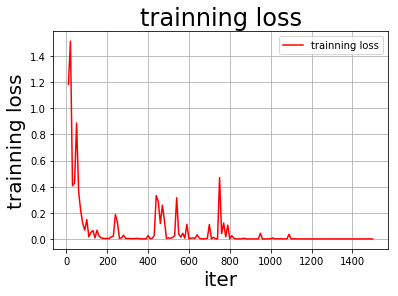

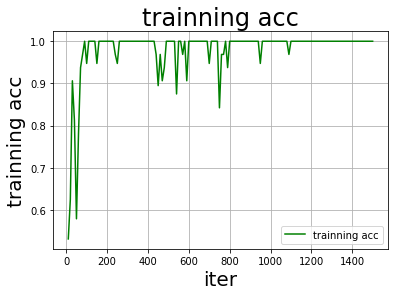

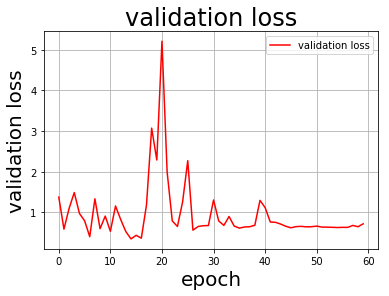

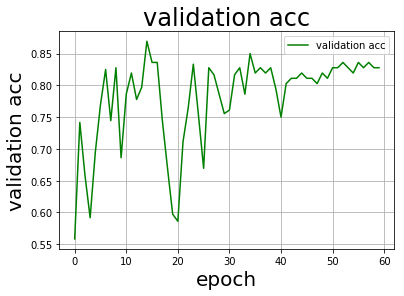

In [17]:
import time
cross_entropy = paddle.nn.CrossEntropyLoss()

optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 
# optimizer = paddle.optimizer.SGD(learning_rate=train_parameters['learning_strategy']['lr'],
#                                   parameters=model.parameters()) 
# optimizer = paddle.optimizer.Adagrad(learning_rate=train_parameters['learning_strategy']['lr'],
#                                   parameters=model.parameters()) 
# optimizer = paddle.optimizer.Momentum(learning_rate=train_parameters['learning_strategy']['lr'],
#                                   parameters=model.parameters()) 

                                  
                                  
                                  

steps = 0
Iters, total_loss, total_acc = [], [], []
val_iters, val_loss, val_acc = [], [], []
best_validate = 0

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
# 实现模型的训练过程和可视化
for epo in range(train_parameters['num_epochs']):
    model.train()
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts, acc = model(x_data, y_data)
        loss = cross_entropy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo+1, steps, loss.numpy(), acc.numpy()))
        
    model.eval()
    epoch_loss, epoch_acc = [], []
    for _, data in enumerate(eval_loader()):
        with paddle.no_grad():
            x_data = data[0]
            y_data = data[1]
            predicts, acc = model(x_data, y_data)
            loss = cross_entropy(predicts, y_data)
            epoch_loss.append(loss.numpy()[0]) 
            epoch_acc.append(acc.numpy()[0]) 
    val_acc.append(np.mean(epoch_acc))
    val_loss.append(np.mean(epoch_loss))
    if val_acc[-1] > best_validate:
        best_validate = val_acc[-1]
        #保存模型参数
        # if steps % train_parameters["save_steps"] == 0:
        save_path = train_parameters["checkpoints"]+"/"+"save_dir_best" + '.pdparams'
        print('save model to: ' + save_path)
        paddle.save(model.state_dict(),save_path)

    print('validation epo: {}, loss is: {}, acc is: {}'\
                  .format(epo, val_loss[-1], val_acc[-1]))


paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")

val_iter = [i for i in range(len(val_loss))]
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")
draw_process("validation loss","red",val_iter, val_loss,"validation loss")
draw_process("validation acc","green",val_iter, val_acc,"validation acc")

In [18]:
print(best_validate)

0.8694445


## 四、模型评估和测试

使用测试集检测模型的性能,采用与训练过程类似的解压数据集操作来解压测试集，以及采用同样的图片转换方式对测试集图片进行预处理

In [19]:
def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path + "Chinese Medicine Infer")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255 # HWC to CHW 及归一化
    return img

infer_src_path = '/home/aistudio/data/data55194/Chinese Medicine Infer.zip'
infer_dst_path = '/home/aistudio/data/'
unzip_infer_data(infer_src_path,infer_dst_path)

label_dic = train_parameters['label_dict']

样本: baihe02.jpg,被预测为:baihe


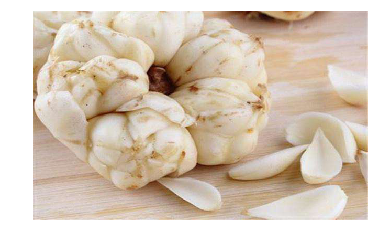

样本: gouqi02.jpg,被预测为:gouqi


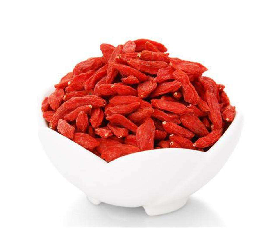

样本: jinyinhua02.jpg,被预测为:jinyinhua


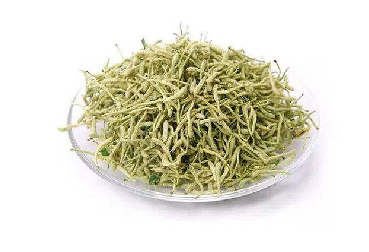

样本: dangshen01.jpg,被预测为:baihe


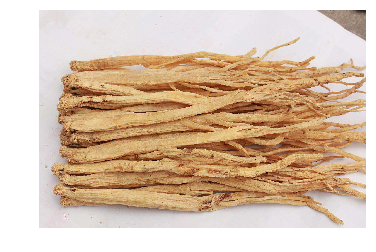

样本: huaihua01.jpg,被预测为:huaihua


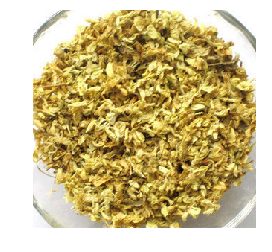

样本: baihe01.jpg,被预测为:baihe


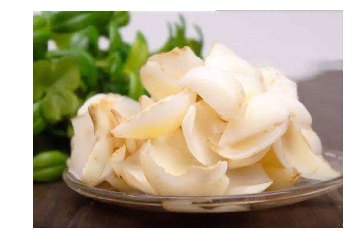

样本: gouqi01.jpg,被预测为:gouqi


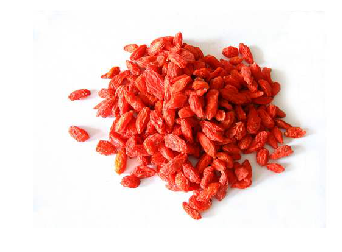

样本: huaihua02.jpg,被预测为:huaihua


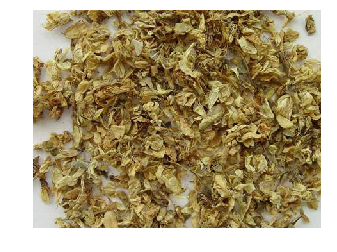

样本: dangshen02.jpg,被预测为:dangshen


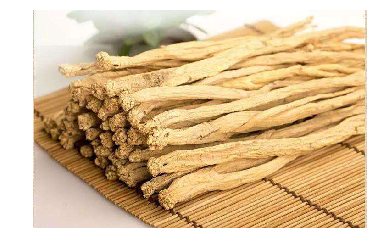

样本: jinyinhua01.jpg,被预测为:jinyinhua


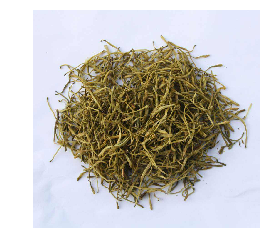

测试模型正确率为： 0.9


In [20]:
model.eval()
infer_imgs_path = os.listdir(infer_dst_path+"Chinese Medicine Infer")
res = []
# 预测所有图片
for infer_img_path in infer_imgs_path:
    infer_img = load_image(infer_dst_path+"Chinese Medicine Infer/"+infer_img_path)
    infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,224,224)
    infer_img = paddle.to_tensor(infer_img)
    result = model(infer_img)
    
    lab = np.argmax(result.numpy())
    res.append(1 if label_dic[str(lab)] in infer_img_path else 0 )
    print("样本: {},被预测为:{}".format(infer_img_path,label_dic[str(lab)]))
    img = Image.open(infer_dst_path+"Chinese Medicine Infer/"+infer_img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    sys.stdout.flush()
    time.sleep(0.5)
# 输出正确率：
print('测试模型正确率为：', np.mean(res))
